#### Agent Architecture
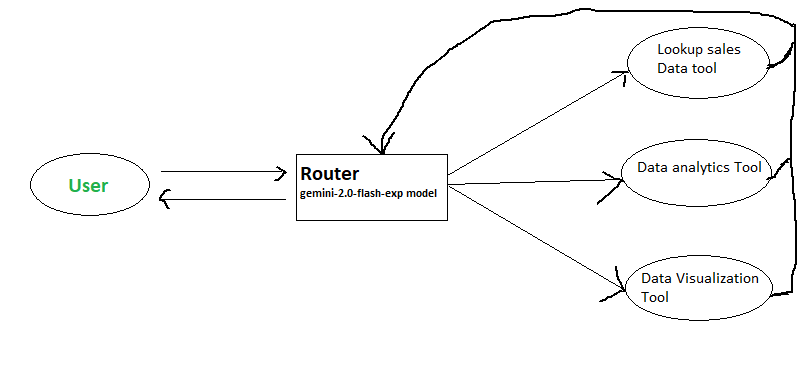

In [1]:
import pandas as pd

df = pd.read_parquet('D:\Langgraph\Store_Sales_Price_Elasticity_Promotions_Data.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697894 entries, 0 to 697893
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Store_Number        697894 non-null  int16  
 1   SKU_Coded           697894 non-null  int32  
 2   Product_Class_Code  697894 non-null  int16  
 3   Sold_Date           697894 non-null  object 
 4   Qty_Sold            697894 non-null  int16  
 5   Total_Sale_Value    697894 non-null  float32
 6   On_Promo            697894 non-null  int8   
dtypes: float32(1), int16(3), int32(1), int8(1), object(1)
memory usage: 15.3+ MB


In [18]:
import os
import re
import pandas as pd
import duckdb
from typing import Annotated, List, Optional, Union, Dict, Any
from typing_extensions import TypedDict
from dotenv import load_dotenv

# LangGraph imports
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import ToolNode

# LangChain imports
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langchain.schema import SystemMessage, HumanMessage

# Load environment variables
load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", api_key=GOOGLE_API_KEY)
memory = InMemorySaver()

#### Defining the tools

Let's start by creating the three tools the agent will be able to use.

#### Tool 1: Database Lookup

This first tool reads from a local parquet file that contains the transaction data.
This database lookup tool works using three steps.
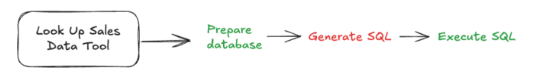

1. First, it creates the SQL table from a local file, if not already done.

2. Second, it translates the original prompt into an sql query (using an LLM call).

3. Finally, it runs that query against the database.

In [2]:
TRANSACTION_DATA_FILE_PATH = 'D:\Langgraph\Store_Sales_Price_Elasticity_Promotions_Data.parquet'

In [3]:
def validate_sql_query(sql: str) -> bool:
    """
    Validate that the SQL query is safe (read-only).
    Only allows SELECT statements and WITH clauses (CTEs).
    
    Args:
        sql: SQL query string to validate
        
    Returns:
        Boolean indicating if query is safe
    """
    if not sql or not isinstance(sql, str):
        return False
    
    # Only allow SELECT or WITH...SELECT statements
    safe_pattern = re.compile(r"^\s*(?:WITH\b[\s\S]+?AS\s*\(|SELECT\b)", re.IGNORECASE)
    return bool(safe_pattern.match(sql.strip()))


def extract_sql_from_response(text: str) -> Optional[str]:
    """
    Extract SQL query from LLM response text.
    Handles various formats like code blocks or plain SQL.
    
    Args:
        text: Raw text from LLM response
        
    Returns:
        Extracted SQL query or None if not found
    """
    if not text:
        return None
    
    # Try to extract from code blocks first (```sql ... ``` or ``` ... ```)
    code_block_match = re.search(r"```(?:sql)?\s*([\s\S]+?)\s*```", text, re.IGNORECASE)
    if code_block_match:
        return code_block_match.group(1).strip()
    
    # Try to find SELECT statement
    select_match = re.search(r"(SELECT\b[\s\S]+?)(?:;|$)", text, re.IGNORECASE)
    if select_match:
        return select_match.group(1).strip()
    
    return None


def generate_sql_query(
    user_request: str,
    table_columns: List[str],
    table_name: str = "sales",
    row_limit: int = 1000
) -> str:
    """
    Generate a SQL query from natural language using the LLM.
    
    Args:
        user_request: Natural language description of what data to fetch
        table_columns: List of available column names
        table_name: Name of the table to query
        row_limit: Maximum number of rows to return (for safety)
        
    Returns:
        Valid SQL query string
        
    Raises:
        ValueError: If generated SQL is invalid or unsafe
    """
    
    # Prepare the column list for the prompt
    columns_text = ", ".join(table_columns) if table_columns else "ALL_COLUMNS"
    
    # System prompt - instructs the LLM to only output SQL
    system_prompt = """You are a SQL expert assistant that ONLY outputs SQL queries.
    Rules:
    - Return ONLY a single SQL query, no explanations
    - Use the exact table name and column names provided
    - Only use SELECT statements (read-only queries)
    - Add appropriate LIMIT clause for safety
    """
    
    # User prompt with the specific request and table info
    user_prompt = f"""
    User request: {user_request}
    
    Table name: {table_name}
    Available columns: {columns_text}
    
    Generate a SQL query to fulfill this request.
    Add 'LIMIT {row_limit}' if not specified.
    """
    
    # Create messages for the LLM
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ]
    
    # Get response from LLM
    response = llm.invoke(messages)
    
    # Extract the SQL from the response
    raw_text = response.content if hasattr(response, 'content') else str(response)
    sql_query = extract_sql_from_response(raw_text) or raw_text.strip()
    
    # Clean up the SQL query
    sql_query = sql_query.strip()
    
    # Add LIMIT if not present (for safety)
    if "limit" not in sql_query.lower():
        sql_query = sql_query.rstrip(";") + f" LIMIT {row_limit}"
    
    # Ensure it ends with semicolon
    if not sql_query.endswith(";"):
        sql_query += ";"
    
    # Validate the SQL for safety
    if not validate_sql_query(sql_query):
        raise ValueError(f"Generated SQL is not safe or valid: {sql_query}")
    
    return sql_query

In [4]:
import duckdb

@tool
def lookup_sales_data(query: str) -> str:
    """
    Look up sales data from the parquet file using natural language queries.
    Converts the query to SQL and executes it against the data.
    
    Args:
        query: Natural language query about sales data
        
    Returns:
        String representation of the query results
    """
    try:
        # Step 1: Load the parquet file into a pandas DataFrame
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        
        # Step 2: Create a DuckDB table from the DataFrame
        table_name = "sales"
        duckdb.sql(f"CREATE OR REPLACE TABLE {table_name} AS SELECT * FROM df")
        
        # Step 3: Generate SQL query from natural language
        sql_query = generate_sql_query(
            user_request=query,
            table_columns=list(df.columns),
            table_name=table_name
        )
        
        print(f"Generated SQL: {sql_query}")  # Debug output
        
        # Step 4: Execute the SQL query
        result_df = duckdb.sql(sql_query).df()
        
        # Step 5: Return results as formatted string
        if result_df.empty:
            return "No data found matching your query."
        
        return f"Query Results:\n{result_df.to_string()}"
        
    except Exception as e:
        return f"Error accessing sales data: {str(e)}"

In [5]:
example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")
print(example_data)

C:\Users\Moorthy\AppData\Local\Temp\ipykernel_2476\3990702206.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")


Generated SQL: SELECT 
    *
    FROM 
    sales
    WHERE 
    Store_Number = 1320
    AND
    Sold_Date = '2021-11-01'
    LIMIT 1000;
Query Results:
    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1    

#### Tool 2: Data Analysis
The second tool can analyze the returned data and display conclusions to users.

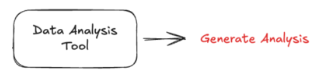

In [6]:
def prepare_data_summary(df: pd.DataFrame, max_rows: int = 5) -> str:
    """
    Create a compact text summary of a DataFrame for LLM analysis.
    
    Args:
        df: DataFrame to summarize
        max_rows: Number of sample rows to include
        
    Returns:
        Formatted string summary of the data
    """
    summary_parts = []
    
    # Add basic info
    summary_parts.append(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    summary_parts.append(f"Columns: {', '.join(df.columns.tolist())}")
    
    # Add sample rows
    summary_parts.append(f"\nFirst {max_rows} rows:")
    summary_parts.append(df.head(max_rows).to_string())
    
    # Add statistical summary for numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) > 0:
        summary_parts.append("\nNumeric Column Statistics:")
        summary_parts.append(df[numeric_cols].describe().to_string())
    
    # Add value counts for categorical columns (if any)
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols[:3]:  # Limit to first 3 categorical columns
        if df[col].nunique() <= 10:  # Only if few unique values
            summary_parts.append(f"\n{col} Value Counts:")
            summary_parts.append(df[col].value_counts().head(5).to_string())
    
    return "\n".join(summary_parts)


@tool
def analyze_sales_data(query: str, data: str) -> str:
    """
    Analyze sales data and provide insights based on the user's question.
    
    Args:
        query: The analytical question to answer
        data: String representation of the data to analyze
        
    Returns:
        Analytical insights as a formatted string
    """
    try:
        # System prompt for analysis
        system_prompt = """You are a expert data analyst for a retail store.
        Analyze the provided sales data and answer the user's question.
        
        Provide your analysis in this format:
        1. KEY INSIGHTS (3 bullet points)
        2. ANOMALIES OR PATTERNS (if any)
        3. RECOMMENDATIONS (2-3 actionable items)
        
        Be specific, use numbers, and base everything on the actual data provided.
        """
        
        # User prompt with data and question
        user_prompt = f"""
        Data to analyze:
        {data}
        
        Question: {query}
        
        Please provide a thorough but concise analysis.
        """
        
        # Create messages for the LLM
        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_prompt)
        ]
        
        # Get analysis from LLM
        response = llm.invoke(messages)
        
        # Extract and return the analysis
        analysis = response.content if hasattr(response, 'content') else str(response)
        return f"Analysis Results:\n{analysis}"
        
    except Exception as e:
        return f"Error analyzing data: {str(e)}"

In [ ]:
example_data

str

In [14]:
# if you already read parquet to df earlier
# df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
answer = analyze_sales_data("What sales trends do you see in the last month?", example_data)
print(answer)


AttributeError: 'str' object has no attribute 'parent_run_id'

#### TOOL 3: DATA VISUALIZATION
This tool generates Python code for creating charts

In [19]:
def extract_chart_configuration(data: str, visualization_goal: str) -> Dict[str, Any]:
    """
    Generate chart configuration from data and visualization requirements.
    
    Args:
        data: String representation of the data
        visualization_goal: Description of desired visualization
        
    Returns:
        Dictionary with chart configuration
    """
    system_prompt = """You are a data visualization expert.
    Based on the data and goal, determine the best chart configuration.
    
    Return a JSON object with these fields:
    - chart_type: "bar", "line", "scatter", "pie", or "histogram"
    - x_axis: column name for x-axis
    - y_axis: column name for y-axis
    - title: descriptive title for the chart
    - description: brief description of what the chart shows
    """
    
    user_prompt = f"""
    Data available:
    {data[:1000]}  # Limit data preview for context window
    
    Visualization goal: {visualization_goal}
    
    Provide the chart configuration as JSON.
    """
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ]
    
    response = llm.invoke(messages)
    content = response.content if hasattr(response, 'content') else str(response)
    
    # Try to parse JSON from response
    try:
        import json
        # Extract JSON from response (handle code blocks)
        json_match = re.search(r'\{[\s\S]+\}', content)
        if json_match:
            config = json.loads(json_match.group())
            return config
    except:
        pass
    
    # Fallback configuration
    return {
        "chart_type": "bar",
        "x_axis": "category",
        "y_axis": "value",
        "title": visualization_goal,
        "description": "Data visualization"
    }


@tool
def generate_visualization(data: str, visualization_goal: str) -> str:
    """
    Generate Python code to create a data visualization.
    
    Args:
        data: String representation of the data to visualize
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Python code to create the visualization
    """
    try:
        # Step 1: Get chart configuration
        config = extract_chart_configuration(data, visualization_goal)
        
        # Step 2: Generate Python code for the chart
        system_prompt = """You are a Python data visualization expert.
        Generate clean, working Python code using matplotlib or seaborn.
        
        Rules:
        - Include all necessary imports
        - Add proper labels and title
        - Make the chart visually appealing
        - Include plt.show() at the end
        - Add comments explaining the code
        - Return ONLY the Python code, no explanations
        """
        
        user_prompt = f"""
        Create Python code for this visualization:
        
        Chart Configuration:
        - Type: {config['chart_type']}
        - X-axis: {config['x_axis']}
        - Y-axis: {config['y_axis']}
        - Title: {config['title']}
        
        Data preview:
        {data[:500]}
        
        Generate complete, runnable Python code.
        """
        
        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_prompt)
        ]
        
        response = llm.invoke(messages)
        code = response.content if hasattr(response, 'content') else str(response)
        
        # Clean the code (remove markdown formatting if present)
        code = code.replace("```python", "").replace("```", "").strip()
        
        return f"Visualization Code:\n\n{code}"
        
    except Exception as e:
        return f"Error generating visualization: {str(e)}"

#### AGENT

In [20]:
class AgentState(TypedDict):
    """
    State definition for the agent.
    Tracks messages and intermediate results throughout the conversation.
    """
    messages: Annotated[List, add_messages]
    current_data: Optional[str]  # Stores data from lookup for use in other tools

# ============================================================================
# AGENT ROUTER FUNCTION
# ============================================================================

def route_query(state: AgentState) -> str:
    """
    Router function that decides which tool to use based on the user's query.
    
    Args:
        state: Current agent state with messages
        
    Returns:
        Name of the next node to execute
    """
    # Get the last user message
    messages = state["messages"]
    last_message = messages[-1]
    
    # Extract the query text
    query = last_message.content if hasattr(last_message, 'content') else str(last_message)
    query_lower = query.lower()
    
    # Routing logic based on keywords and intent
    
    # Check for data lookup requests
    lookup_keywords = ['show', 'get', 'fetch', 'find', 'lookup', 'retrieve', 'what is', 'list', 'display']
    if any(keyword in query_lower for keyword in lookup_keywords):
        return "lookup_data"
    
    # Check for analysis requests
    analysis_keywords = ['analyze', 'insight', 'trend', 'pattern', 'anomaly', 'explain', 'why', 'correlation']
    if any(keyword in query_lower for keyword in analysis_keywords):
        return "analyze_data"
    
    # Check for visualization requests
    viz_keywords = ['chart', 'graph', 'plot', 'visualize', 'draw', 'diagram', 'histogram', 'bar', 'line']
    if any(keyword in query_lower for keyword in viz_keywords):
        return "visualize_data"
    
    # Default to lookup if unclear
    return "lookup_data"




In [21]:
# ============================================================================
# NODE FUNCTIONS FOR THE GRAPH
# ============================================================================

def lookup_node(state: AgentState) -> AgentState:
    """Node that handles data lookup"""
    messages = state["messages"]
    last_message = messages[-1]
    query = last_message.content if hasattr(last_message, 'content') else str(last_message)
    
    # Execute the lookup tool
    result = lookup_sales_data.invoke({"query": query})
    
    # Update state with the result
    state["current_data"] = result
    state["messages"].append(HumanMessage(content=result))
    
    return state

def analyze_node(state: AgentState) -> AgentState:
    """Node that handles data analysis"""
    messages = state["messages"]
    last_message = messages[-1]
    query = last_message.content if hasattr(last_message, 'content') else str(last_message)
    
    # Use current data if available, otherwise fetch it first
    data = state.get("current_data", "")
    if not data:
        # First lookup the data
        lookup_result = lookup_sales_data.invoke({"query": query})
        data = lookup_result
    
    # Execute the analysis tool
    result = analyze_sales_data.invoke({"query": query, "data": data})
    
    # Update state with the result
    state["messages"].append(HumanMessage(content=result))
    
    return state

def visualize_node(state: AgentState) -> AgentState:
    """Node that handles visualization generation"""
    messages = state["messages"]
    last_message = messages[-1]
    query = last_message.content if hasattr(last_message, 'content') else str(last_message)
    
    # Use current data if available
    data = state.get("current_data", "")
    if not data:
        # Need to fetch data first
        lookup_result = lookup_sales_data.invoke({"query": "Show sample sales data"})
        data = lookup_result
    
    # Execute the visualization tool
    result = generate_visualization.invoke({"data": data, "visualization_goal": query})
    
    # Update state with the result
    state["messages"].append(HumanMessage(content=result))
    
    return state

In [26]:
# ============================================================================
# BUILD THE LANGGRAPH
# ============================================================================

# def create_sales_agent():
#     """
#     Create and configure the LangGraph agent for sales data analysis.
    
#     Returns:
#         Compiled LangGraph workflow
#     """
#     # Initialize the graph with our state schema
#     workflow = StateGraph(AgentState)

#     # --- router node must be a pass-through node (returns state) ---
#     def router_node(state: AgentState) -> AgentState:
#         return state
    
#     # Add nodes to the graph
#     workflow.add_node("router", route_query)
#     workflow.add_node("lookup_data", lookup_node)
#     workflow.add_node("analyze_data", analyze_node)
#     workflow.add_node("visualize_data", visualize_node)
    
#     # Define the edges (connections between nodes)
#     workflow.add_edge(START, "router")
    
#     # Add conditional edges from router to tools
#     workflow.add_conditional_edges(
#         "router",
#         lambda x: route_query(x),
#         {
#             "lookup_data": "lookup_data",
#             "analyze_data": "analyze_data",
#             "visualize_data": "visualize_data"
#         }
#     )
    
#     # All tool nodes lead to END
#     workflow.add_edge("lookup_data", END)
#     workflow.add_edge("analyze_data", END)
#     workflow.add_edge("visualize_data", END)
    
#     # Compile the graph
#     app = workflow.compile(checkpointer=memory)
    
#     return app


def create_sales_agent():
    """
    Create and configure the LangGraph agent for sales data analysis.
    Returns:
        Compiled LangGraph workflow
    """
    # Initialize the graph with our state schema
    workflow = StateGraph(AgentState)

    # --- router node must be a pass-through node (returns state) ---
    def router_node(state: AgentState) -> AgentState:
        return state

    # Add nodes to the graph
    workflow.add_node("router", router_node)
    workflow.add_node("lookup_data", lookup_node)
    workflow.add_node("analyze_data", analyze_node)
    workflow.add_node("visualize_data", visualize_node)

    # Define the edges (connections between nodes)
    workflow.add_edge(START, "router")

    # Add conditional edges from router to tools
    # the second arg must be a function that maps state -> key in mapping
    workflow.add_conditional_edges(
        "router",
        lambda st: route_query(st),   # route_query returns "lookup_data" / "analyze_data" / "visualize_data"
        {
            "lookup_data": "lookup_data",
            "analyze_data": "analyze_data",
            "visualize_data": "visualize_data"
        }
    )

    # All tool nodes lead to END
    workflow.add_edge("lookup_data", END)
    workflow.add_edge("analyze_data", END)
    workflow.add_edge("visualize_data", END)

    # Compile the graph
    app = workflow.compile(checkpointer=memory)

    return app


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def run_agent(query: str):
    """
    Run the agent with a user query.
    
    Args:
        query: User's natural language query
        
    Returns:
        Agent's response
    """
    # Create the agent
    agent = create_sales_agent()
    
    # Prepare initial state
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "current_data": None
    }
    
    # Run the agent
    result = agent.invoke(initial_state, {"configurable": {"thread_id": "1"}})
    
    # Extract and return the final response
    if result["messages"]:
        final_message = result["messages"][-1]
        return final_message.content if hasattr(final_message, 'content') else str(final_message)
    
    return "No response generated"

In [28]:
response = run_agent('Analyze the sales trends for the last month')
print(f"Response:\n{response}")

Generated SQL: SELECT
        Sold_Date,
        SUM(Total_Sale_Value) AS Daily_Sales
    FROM
        sales
    WHERE
        Sold_Date >= date('now', '-1 month')
    GROUP BY
        Sold_Date
    ORDER BY
        Sold_Date
    LIMIT 1000;
Response:
Analysis Results:
I am sorry, but I am unable to analyze the sales data because I encountered an error when trying to access it. The error message indicates a problem with the DATE function, suggesting an issue with the data format or the query used to retrieve the data.
